**AutoML OSS入門（10）**

# Google発ニューラルネットワークに特化したAutoML「Model Search」

本ノートブックの紹介記事と併せてご覧ください。
- ＠IT連載 AutoML OSS入門（10）- Google発ニューラルネットワークに特化したAutoML「Model Search」

なお、本ノートブックの扱い方や使用するデータについては、連載記事の第1回を参照してください。
- [＠IT連載 AutoML OSS入門（１）- 第1回「機械学習モデル構築作業の煩雑さを解消する「AutoML」とは――歴史、動向、利用のメリットを整理する」](https://www.atmarkit.co.jp/ait/articles/2107/02/news006.html)

## apple2orangeでAutoML

cycle_ganのapple2orangeを使って、Model Searchによる画像分類を紹介していきます。

なお、学習時間を短縮するため、Colab上部の「ランタイム」タブから「ランタイムのタイプを変更」をクリックし、「ハードウェアアクセラレータ」を「GPU」に設定してください。

### セットアップ

Google Colab上にModel Searchの実行環境を構築します。

In [ ]:
# GitHubからModel Searchのソースを取得
!git clone https://github.com/google/model_search

# 関連ライブラリのインストール
!pip install folium==0.2.1
!pip install -r model_search/requirements.txt

Cloning into 'model_search'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 203 (delta 6), reused 22 (delta 4), pack-reused 170
Receiving objects: 100% (203/203), 252.61 KiB | 6.83 MiB/s, done.
Resolving deltas: 100% (59/59), done.
     |████████████████████████████████| 69 kB 3.2 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79809 sha256=6c171f2bf8f60ae1fd04aa134b8eaaff7d429bc479c894aa0e59e12da5080c9a
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
     |████████████████████████████████| 516.2 MB 4.3 kB/s 
     |████████████████████████████████| 127 kB 71.8 MB/s 
     |████████████████████████████████| 352 kB 69.1 MB/s

In [ ]:
# 画像処理用にtensorflowのバージョンを変更
!pip install tensorflow==2.3.0

     |████████████████████████████████| 320.4 MB 48 kB/s 
     |████████████████████████████████| 459 kB 76.2 MB/s 
     |████████████████████████████████| 5.8 MB 30.3 MB/s 
     |████████████████████████████████| 20.1 MB 17.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0
ERROR: pip's dependency resolver does not currently take into accoun

(注) ランタイムを再起動してください。
- ランタイムの再起動方法<br>
ランタイム > ランタイムを再起動 を実行

In [ ]:
# 取得したディレクトリ内に移動後、protoファイルをコンパイル
%cd /content/model_search
!protoc --python_out=./ model_search/proto/*.proto

/content/model_search


In [ ]:
import sys
from absl import app
from absl import flags
from absl import logging

# Model SearchのインポートやAutoML実行のエラー回避用コードを実行
FLAGS = flags.FLAGS

sys.argv = sys.argv[:1]
try:
    app.run(lambda argv: None)
except:
    pass

# 実行ログをファイルに出力するように設定
logging.get_absl_handler().use_absl_log_file('modelSearch','./') 
flags.FLAGS.mark_as_parsed()

### データのロード

apple2orangeのデータセットをダウンロードします。

※apple2orangeはリンゴとオレンジの2クラスの画像で構成されたデータセットです。詳細は、[こちら](https://www.tensorflow.org/datasets/catalog/cycle_gan)を参照してください。

In [ ]:
# データのダウンロード
import tensorflow_datasets as tfds

dataset, ds_info = tfds.load('cycle_gan/apple2orange', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteWKW2J6/cycle_gan-trainA.tfrecord


  0%|          | 0/995 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteWKW2J6/cycle_gan-trainB.tfrecord


  0%|          | 0/1019 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteWKW2J6/cycle_gan-testA.tfrecord


  0%|          | 0/266 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompleteWKW2J6/cycle_gan-testB.tfrecord


  0%|          | 0/248 [00:00<?, ? examples/s]

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# データセットに格納された情報を確認
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

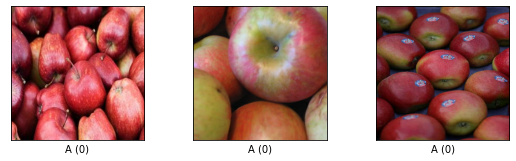

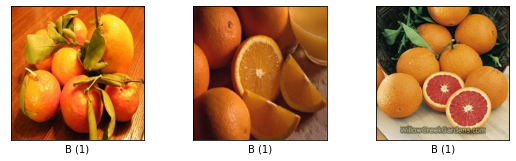

In [ ]:
# データセットの一部を描画
apple_fig = tfds.show_examples(dataset['trainA'].take(3), ds_info)
orange_fig = tfds.show_examples(dataset['trainB'].take(3), ds_info)

### データの前処理

Model Searchでは特徴量エンジニアリングなどの前処理機能が提供されていないため、学習用およびテスト用データセットに対して簡単な前処理を実施後、画像ファイルとして保存します。

In [ ]:
# ラベル毎にイメージをJPEG形式で保存
import os
import numpy as np
from PIL import Image


def saveImages(root_dir, ds, ds_info):
    """
    画像データを縦横256×256のjpegファイルとして保存する。

    Parameters
    ----------
    root_dir : string
        jpegファイルの保存先ディレクトリ名。
    ds : Image
        画像データセット。
    ds_info : FeaturesDict
        画像データセットのメタ情報。

    Returns
    -------
    なし
    """
    # 保存用ディレクトリを作成
    for i in range(ds_info.features['label'].num_classes):
        label = str(i)
        os.makedirs(root_dir + label, exist_ok=True)

    # イメージを保存
    for i, data in enumerate(tfds.as_numpy(X_train)):
        image, label = data

        # イメージの正規化
        image_array = image
        image_norm = 255.0 * \
            ((image_array - image_array.min()) /
                (image_array.max() - image_array.min()))

        # イメージの縦横比を統一(256 × 256)し、保存
        image = Image.fromarray(image_norm.astype('uint8'))
        image = image.resize((256, 256))
        image.save(root_dir + str(label) + '/' +
                    str(i) + '.jpeg', format='JPEG')

In [ ]:
# 学習用およびテスト用データセットを画像ファイルとして保存
X_train = dataset['trainA'].concatenate(dataset['trainB'])
saveImages('data/train/', X_train, ds_info)

X_test = dataset['testA'].concatenate(dataset['testB'])
saveImages('data/test/', X_test, ds_info)

### ライブラリのインポート

In [ ]:
# Model Searchの関連ライブラリをインポート
import model_search
from model_search import single_trainer
from model_search.data import image_data

import tensorflow as tf

# 乱数の固定
tf.random.set_seed(42)

### モデルの学習

Model Searchを用いた最適なニューラルネットワーク構造の自動探索を行います。

なお、モデルの構築および学習の実行途中にOOM（Out Of Memory）の発生が時折確認されています。
Model Searchでは実行途中からでも探索を再開できるため、OOMが発生した際は再度以下の処理を実行してください。

In [ ]:
# モデル構築用インスタンスを準備
trainer = single_trainer.SingleTrainer(
    data=image_data.Provider(
        input_dir='data/train/',
        image_height=256,
        image_width=256,
        eval_fraction=0.2),
    spec='model_search/configs/cnn_config.pbtxt')

In [ ]:
# モデルの構築および学習
with tf.device('/device:GPU:0'):
    trainer.try_models(
        number_models=200,
        train_steps=2000,
        eval_steps=100,
        root_dir='apple2orange_model',
        batch_size=32,
        experiment_name='apple2orange',
        experiment_owner='model_search_user')

Found 2014 files belonging to 2 classes.
Using 1612 files for training.
Found 2014 files belonging to 2 classes.
Using 402 files for validation.
Found 2014 files belonging to 2 classes.
Using 1612 files for training.
Found 2014 files belonging to 2 classes.
Using 402 files for validation.
Found 2014 files belonging to 2 classes.
Using 1612 files for training.
Found 2014 files belonging to 2 classes.
Using 402 files for validation.
Found 2014 files belonging to 2 classes.
Using 1612 files for training.
Found 2014 files belonging to 2 classes.
Using 402 files for validation.
Found 2014 files belonging to 2 classes.
Using 1612 files for training.
Found 2014 files belonging to 2 classes.
Using 402 files for validation.
Found 2014 files belonging to 2 classes.
Using 1612 files for training.
Found 2014 files belonging to 2 classes.
Using 402 files for validation.
Found 2014 files belonging to 2 classes.
Using 1612 files for training.
Found 2014 files belonging to 2 classes.
Using 402 files f

In [ ]:
# 探索時に構築されたモデルは、ディレクト毎に保存されていることを確認
!ls -r apple2orange_model/tuner-1/

99  88	77  66	55  44	33  22	 193  182  171	160  15   139  128  117  106
98  87	76  65	54  43	32  21	 192  181  170	16   149  138  127  116  105
97  86	75  64	53  42	31  201  191  180  17	159  148  137  126  115  104
96  85	74  63	52  41	30  200  190  18   169	158  147  136  125  114  103
95  84	73  62	51  40	3   20	 19   179  168	157  146  135  124  113  102
94  83	72  61	50  4	29  2	 189  178  167	156  145  134  123  112  101
93  82	71  60	5   39	28  199  188  177  166	155  144  133  122  111  100
92  81	70  6	49  38	27  198  187  176  165	154  143  132  121  110  10
91  80	7   59	48  37	26  197  186  175  164	153  142  131  120  11	 1
90  8	69  58	47  36	25  196  185  174  163	152  141  130  12   109
9   79	68  57	46  35	24  195  184  173  162	151  140  13   119  108
89  78	67  56	45  34	23  194  183  172  161	150  14   129  118  107


In [ ]:
# ログから最も精度が良かったモデルとその精度を取得
import subprocess
import re

best_model_no = '0'
best_accuracy = 0.0
proc = subprocess.Popen(['cat', 'modelSearch.INFO'], stdout=subprocess.PIPE)
for line in proc.stdout:
    str_line = line.decode('utf-8')
    if 'creating directory' in str_line:
        model_no = str_line.strip('\n').split('/')[2]
    elif "Evaluation results: {'accuracy'" in str(line):
        model_accuracy = float(re.findall(
            "Evaluation results: {'accuracy': (.*), 'auc_pr'.*", str_line)[0])
        if (model_accuracy >= best_accuracy):
            best_accuracy = model_accuracy
            best_model_no = model_no

print(f'最も精度が良かったモデルのNo.:{best_model_no}')
print(f'モデルの精度:{best_accuracy}')

最も精度が良かったモデルのNo.:172
モデルの精度:0.91542286


### 予測

構築したモデルで予測を行います。

In [ ]:
# モデルが保存されているフォルダ名を取得
model_dir = os.listdir(f'apple2orange_model/tuner-1/{best_model_no}/saved_model/')[0]

# モデルの入出力に関する仕様を確認
!saved_model_cli show --dir apple2orange_model/tuner-1/$best_model_no/saved_model/$model_dir --all

2021-12-12 10:19:20.256095: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 256, 256, 3)
        name: image:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['log_probabilities'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: Phoenix/Trainer/LogSoftmax:0
    outputs['logits'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: Phoenix/search_generator_0/last_dense_2197234232524/logits:0
    outputs['predictions'] tensor_info:
        dtype: DT_INT64
        shape: (-1)
        name: Phoenix/Trainer/ArgMax:0
    outputs['probabilities'] tensor_info:
        dtype: DT_FLOAT
        shap

In [ ]:
# テスト用データを基に構築したモデルで予測を実行
import glob

num_correct_pred = 0
num_test_images = 0
label_dict = {0: 'リンゴ', 1: 'オレンジ'}
for label in label_dict.keys():
    images = []
    tf.keras.backend.clear_session()

    # 画像ファイルを読み込み、リストへ格納
    for file_path in glob.glob('data/test/' + str(label) + '/*'):
        jpeg_r = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(jpeg_r, channels=3)
        image = tf.image.resize(image, [256, 256])
        image_float = tf.image.convert_image_dtype(image, tf.float32)
        images.append(image_float)

    # 構築したモデルをロードし、予測を実行
    trained_model = tf.keras.models.load_model(
        f'apple2orange_model/tuner-1/{best_model_no}/saved_model/{model_dir}')
    inputs = {
        'image': tf.convert_to_tensor(images[:200])
    }
    result = trained_model.signatures['serving_default'](**inputs)
    preds = tf.keras.backend.get_value(result['predictions'])
    labels = [label for i in range(len(preds))]
    print(
        f'{label_dict[label]}に関する正解率： {(np.count_nonzero(preds == labels) / len(preds)) * 100.0:2.2f}%')

    # 正解数およびテスト用データ数を格納
    num_correct_pred += np.count_nonzero(preds == labels)
    num_test_images += len(preds)

print('===========')
# モデルの正解率を計算
print(f'モデルの正解率: {(num_correct_pred / num_test_images) * 100.0:2.2f}%')

リンゴに関する正解率： 91.00%
オレンジに関する正解率： 93.00%
モデルの正解率: 92.00%


以上で、データセット「apple2orange」を使ったModel Searchの画像分類に関する解説は終了です。